# Parcel Descent
Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021

In this notebook, we adapt the ascent calculations for descending parcels. We aim to:
 - Consider a parcel with given initial pressure, temperature and condensed water content and determine how these change as the parcel descends, and
 - Consider a very basic model of entrainment.
 
## Table of Contents
- [Finding the evaporation level](#Finding-the-evaporation-level)
- [Descent calculation](#Descent-calculation)
- [Specfic humidity vs. pressure and intial liquid water content for constant initial temperature](#Specfic-humidity-vs.-pressure-and-intial-liquid-water-content-for-constant-initial-temperature)
- [Specfic humidity vs. pressure and initial temperature for constant intial liquid water content](#Specfic-humidity-vs.-pressure-and-initial-temperature-for-constant-intial-liquid-water-content)
- [Modelling entrainment](#Modelling-entrainment)
- [Questions](#Questions)
- [Possible next steps](#Possible-next-steps)

In [1]:
from scipy.optimize import fixed_point
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
from scipy.optimize import root_scalar
from os import mkdir
from os.path import exists

In [2]:
fig_path = ('/Users/tschanzer/OneDrive - UNSW/UNSW2021/T3/ToR/'
            'taste-of-research-21T3/analysis/20210906_parcel_descent_figures/')
if not exists(fig_path):
    mkdir(fig_path)

## Finding the evaporation level
We assume that the parcel is initially saturated and has additional condensed water, which evaporates as parcel descends.
The parcel will descend moist adiabatically until no condensed water is left, i.e., the new saturation mixing ratio is equal to the original total mixing ratio (liquid plus vapour):

$$
    w_s' = w_v + w_l = w_s + w_l \\ 
    \Leftrightarrow \qquad q^{*}(p', T(p')) = q^{*}(p_0, T_0) + \frac{\rho_l}{\rho} \\
    \Leftrightarrow \qquad q^{*}(p_0, T_0) + \frac{\rho_l}{\rho} - q^{*}(p', T(p')) \equiv f(p') = 0
$$

MetPy does not have a function that does this. We will find the pressure $p'$ at which this occurs using a root-finding algorithm  
($\verb |scipy.optimize.root_scalar|$), similar to how MetPy uses fixed-point iteration to find the LCL.

In [3]:
# this is the objective function for the root-finding algorithm
def remaining_liquid_ratio(
        pressure, initial_pressure, initial_temperature,
        initial_liquid_ratio):
    """
    Calculates the amount of liquid water left in the parcel.
    
    It is assumed that the parcel is initially saturated.
    The arguments must be given as plain numbers, without units.
    
    Args:
        pressure: The pressure level of interest in millibars.
        initial_pressure: The initial pressure of the parcel in
            millibars.
        initial_temperature: The initial temperature of the parcel in
            degrees celsius.
        initial_liquid_ratio: The ratio of the initial mass of liquid
            water to the total mass of the parcel.
            
    Returns:
        The ratio of the remaining mass of liquid water to the total
            mass of the parcel.
    """
    
    pressure = pressure*units.mbar
    initial_pressure = initial_pressure*units.mbar
    initial_temperature = initial_temperature*units.celsius
    
    initial_specific_humidity = mpcalc.specific_humidity_from_dewpoint(
        initial_pressure, initial_temperature)
    final_temperature = mpcalc.moist_lapse(
        pressure, initial_temperature, reference_pressure=initial_pressure)
    final_specific_humidity = mpcalc.specific_humidity_from_dewpoint(
        pressure, final_temperature)
    remaining_ratio = (initial_specific_humidity + initial_liquid_ratio
                       - final_specific_humidity)
    
    return remaining_ratio

def evaporation_level(
        initial_pressure, initial_temperature, initial_liquid_ratio,
        tolerance=1e-5, max_iterations=50):
    """
    Finds the pressure at which all liquid water evaporates.
    
    Args:
        initial_pressure: The initial pressure of the parcel.
        initial_temperature: The initial temperature of the parcel.
        initial_liquid_ratio: The ratio of the initial mass of liquid
            water to the total mass of the parcel.
        tolerance: Tolerance for absolute error (optional, default
            1e-5 mbar).
        max_iterations: Maximum number of iterations of the root-finding
            algorithm (optional, default 50).
            
    Returns:
        The pressure at which all liquid water evaporates.
    """
    
    # root_scalar only works with plain numbers so we must strip
    # the units
    initial_pressure = initial_pressure.to(units.mbar).magnitude
    initial_temperature = initial_temperature.to(units.celsius).magnitude
    
    solution = root_scalar(
        remaining_liquid_ratio,
        args=(initial_pressure, initial_temperature, initial_liquid_ratio),
        bracket=[initial_pressure, 1100],
        xtol=tolerance, maxiter=max_iterations)
    
    return solution.root*units.mbar

We can plot a typical example, showing the calculated evaporation level:

In [20]:
%%time
initial_pressure = 600
pressure = np.arange(initial_pressure + 10, 1001, 10)
initial_temperature = -20
initial_liquid_ratio = 3e-3

remaining_liquid = remaining_liquid_ratio(
    pressure, initial_pressure, initial_temperature, initial_liquid_ratio)
level = evaporation_level(
    initial_pressure*units.mbar, initial_temperature*units.celsius,
    initial_liquid_ratio)
error = remaining_liquid_ratio(
    level.m, initial_pressure, initial_temperature, initial_liquid_ratio)

CPU times: user 509 ms, sys: 8.59 ms, total: 518 ms
Wall time: 522 ms


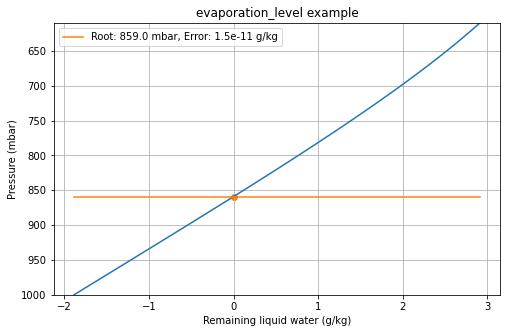

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(remaining_liquid*1e3, pressure)
ax.plot(
    remaining_liquid*1e3, np.ones(len(pressure))*level,
    label='Root: {0:.1f} mbar, Error: {1:.1e} g/kg'.format(level.m, error.m))
ax.scatter(0, level, color='tab:orange')

ax.set_ylim(np.max(pressure), np.min(pressure))
ax.legend()
ax.grid()
ax.set(
    xlabel='Remaining liquid water (g/kg)',
    ylabel='Pressure (mbar)',
    title='evaporation_level example')
plt.show()

## Descent calculation

Now that we are able to find the evaporation level, we can determine the parcel profile, separating it into moist descent above the evaporation level and dry descent below:

In [7]:
def individual_descent_profile(
        pressure, initial_temperature, initial_liquid_ratio):
    """
    Calculates the temperature of a descending air parcel.
    
    The parcel has some initial liquid water content and is assumed
    to be initially saturated.
    
    Args:
        pressure: Pressure levels of interest (must be monotonically
            increasing).
        initial_temperature: Initial temperature of the parcel,
            corresponding to pressure[0].
        initial_liquid_ratio: Initial ratio of liquid water mass to
            total mass.
            
    Returns:
        A tuple containing:
            The array of temperatures at the specified pressure levels,
            the evaporation level, and
            the temperature at the evaporation level.
    """
    
    if initial_liquid_ratio < 0:
        raise ValueError('The initial liquid ratio must be non-negative.')
        
    level = evaporation_level(
        pressure[0], initial_temperature, initial_liquid_ratio
    ).to(pressure.units)
    
    # find the position of the evaporation level in the pressure array
    level_index = np.searchsorted(pressure.m, level.m, side='left')
    
    # moist descent to the evaporation level
    if initial_liquid_ratio > 0:
        # if level_index == 1, pressure[1:level_index] will be empty
        # and moist_lapse cannot handle empty pressure arrays
        if level_index > 1:
            moist_temperature = mpcalc.moist_lapse(
                pressure[1:level_index], initial_temperature,
                reference_pressure=pressure[0])
        else:
            moist_temperature = np.array([])*initial_temperature.units
            
        moist_temperature = concatenate(
            [initial_temperature, moist_temperature])
        
        # temperature at the evaporation level
        level_temperature = mpcalc.moist_lapse(
            level, initial_temperature, reference_pressure=pressure[0])
    else:
        # if there is no liquid water, there is no moist descent
        # and the temperature at the evaporation level is the initial
        # temperature
        moist_temperature = np.array([])*initial_temperature.units
        level_temperature = initial_temperature
    
    # dry descent from the evaporation level
    dry_temperature = mpcalc.dry_lapse(
        pressure[level_index:], level_temperature, reference_pressure=level)
    
    temperature = concatenate([moist_temperature, dry_temperature])
    
    return temperature, level, level_temperature

We then adapt the profile function to calculate several profiles with different initial conditions at once:

In [8]:
def descent_profile_with_evaporation_level(
        pressure, initial_temperatures, initial_liquid_ratios):
    """
    Calculates the temperatures of a descending air parcels.
    
    The parcels have some initial liquid water content and are assumed
    to be initially saturated.
    
    Args:
        pressure: Pressure levels of interest (must be monotonically
            increasing).
        initial_temperatures: Initial temperatures of the parcels,
            corresponding to pressure[0].
        initial_liquid_ratios: Initial ratios of liquid water mass to
            total mass.
            
    Returns:
        A tuple containing:
            The array of temperatures at the specified pressure levels,
            the evaporation levels, and
            the temperatures at the evaporation levels.
    """
    
    # in case only one profile is needed
    initial_temperatures = np.atleast_1d(initial_temperatures)
    initial_liquid_ratios = np.atleast_1d(initial_liquid_ratios)
    
    profiles_with_evaporation_levels = np.array([
        [individual_descent_profile(
            pressure, initial_temperature, initial_liquid_ratio)]
        for initial_temperature, initial_liquid_ratio in zip(
            initial_temperatures, initial_liquid_ratios)
    ], dtype='object')
    
    profiles = profiles_with_evaporation_levels[:,:,0].tolist()
    levels = profiles_with_evaporation_levels[:,0,1].tolist()
    level_temperatures = profiles_with_evaporation_levels[:,0,2].tolist()
    
    profiles = concatenate(profiles).m*initial_temperatures.units
    profiles = np.squeeze(profiles)
    levels = concatenate(levels)
    level_temperatures = concatenate(level_temperatures)
    
    return profiles, levels, level_temperatures

def descent_profile(pressure, initial_temperatures, initial_liquid_ratios):
    """
    Calculates the temperatures of a descending air parcels.
    
    The parcels have some initial liquid water content and are assumed
    to be initially saturated.
    
    Args:
        pressure: Pressure levels of interest (must be monotonically
            increasing).
        initial_temperatures: Initial temperatures of the parcels,
            corresponding to pressure[0].
        initial_liquid_ratios: Initial ratios of liquid water mass to
            total mass.
            
    Returns:
        The array of temperatures at the specified pressure levels,
    """
    
    return descent_profile_with_evaporation_level(
        pressure, initial_temperatures, initial_liquid_ratios)[0]

In a similar manner to the ascent calculations, we can find the specific humidity from a profile:

In [9]:
def specific_humidity_from_descent_profile(
        pressure, temperatures, levels, level_temperatures):
    """
    Calculates the specific humidity of descending parcels.
    
    Args:
        pressure: Pressure levels of interest.
        temperature: Array of parcel temperatures with each row
            corresponding to a different initial specific humidity.
        levels: Evaporation levels of the parcels.
        level_temperatures: Temperatures of the parcels at their
            evaporation levels.
            
    Returns:
        The specific humidities of the parcels at the specified pressure
        levels, as an array with one row for each parcel.
    """
    
    levels = np.atleast_1d(levels)
    level_temperatures = np.atleast_1d(level_temperatures)
    temperatures = np.atleast_2d(temperatures)
    
    specific_humidities = concatenate([[
        concatenate([
            # dew point above the evaporation level is the temperature
            mpcalc.specific_humidity_from_dewpoint(
                pressure[pressure <= levels[i]],
                temperatures[i, pressure <= levels[i]]),
            # specific humidity below the evaporation level is the
            # specific humidity at the evaporation level
            (np.ones(np.sum(pressure > levels[i])) 
             * mpcalc.specific_humidity_from_dewpoint(
                 levels[i], level_temperatures[i])
            )
        ])
        for i in range(len(levels))
    ]])
    
    return specific_humidities

We can also modify the root-finding objective function to give the (non-negative) amount of liquid water remaining:

In [10]:
def actual_remaining_liquid_ratio(
        pressure, initial_temperatures, initial_liquid_ratios):
    """
    Calculates the amount of liquid water left in parcels.
    
    It is assumed that the parcels are initially saturated.
    
    Args:
        pressure: The pressure level of interest.
        initial_temperatures: The initial temperatures of the parcels.
        initial_liquid_ratios: The ratios of the initial masses of
            liquid water to the total masses of the parcels.
            
    Returns:
        The ratios of the remaining masses of liquid water to the total
            masses of the parcels (always nonnegative), as an array
            with one row for each parcel.
    """
    
    initial_specific_humidities = mpcalc.specific_humidity_from_dewpoint(
        pressure[0], initial_temperatures)
    
    final_temperatures = concatenate([[
        [initial_temperature.m, *mpcalc.moist_lapse(
            pressure[1:], initial_temperature,
            reference_pressure=pressure[0]).m]
        for initial_temperature in initial_temperatures
    ]]).m*initial_temperatures.units
    
    final_specific_humidities = concatenate([
        [mpcalc.specific_humidity_from_dewpoint(
            pressure, final_temperatures[i,:])]
        for i in range(final_temperatures.shape[0])
    ])
    
    remaining_ratios = (np.atleast_2d(initial_specific_humidities).T
                       + np.atleast_2d(initial_liquid_ratios).T
                       - final_specific_humidities)
    
    # if ratio is negative, then no liquid is left
    return np.maximum(0, remaining_ratios)

A typical example is shown below.

In [11]:
%%time
pressure = np.arange(400, 1001, 10)*units.mbar
profile1 = descent_profile_with_evaporation_level(
    pressure, [-20, -30]*units.celsius, [8e-3, 8e-3])
profile2 = descent_profile_with_evaporation_level(
    pressure, [-20, -30]*units.celsius, [4e-3, 4e-3])
specific_humidity1 = specific_humidity_from_descent_profile(
    pressure, *profile1)
specific_humidity2 = specific_humidity_from_descent_profile(
    pressure, *profile2)

CPU times: user 2.74 s, sys: 37.4 ms, total: 2.78 s
Wall time: 3.13 s


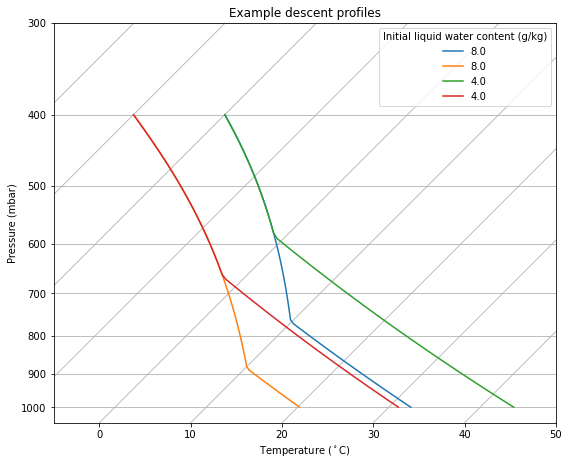

In [12]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, subplot=(1,1,1), rotation=45)
skew.plot(pressure, profile1[0].T, label='8.0')
skew.plot(pressure, profile2[0].T, label='4.0')
skew.ax.set_ylim(1050, 300)
skew.ax.set_xlim(-5, 50)
skew.ax.legend(title='Initial liquid water content (g/kg)')
skew.ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='Example descent profiles')
plt.show()

[Text(0.5, 0, 'Specific humidity (g/kg)'),
 Text(0, 0.5, 'Pressure (mbar)'),
 Text(0.5, 1.0, 'Example specific humidities')]

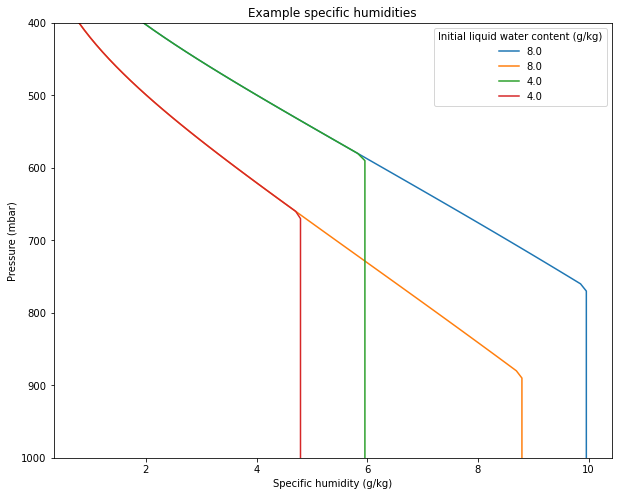

In [13]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.plot(specific_humidity1.T*1e3, pressure, label='8.0')
ax.plot(specific_humidity2.T*1e3, pressure, label='4.0')

ax.legend(title='Initial liquid water content (g/kg)')
ax.set_ylim(np.max(pressure), np.min(pressure))
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Pressure (mbar)',
    title='Example specific humidities')

We can see that the specific humidity increases as liquid water evaporates until the parcel reaches the evaporation level, below which it is constant.

## Specfic humidity vs. pressure and intial liquid water content for constant initial temperature

We now show how the specific humidity of the parcel changes with
pressure for a range of initial liquid water ratios, fixing the initial
temperature.

In [14]:
%%time
pressure = np.arange(400, 1001, 20)*units.mbar
initial_liquid_ratio = np.arange(0, 10.1e-3, 0.2e-3)
initial_temperature = np.ones(len(initial_liquid_ratio)) * -30*units.celsius

profile = descent_profile_with_evaporation_level(
    pressure, initial_temperature, initial_liquid_ratio)
specific_humidity = specific_humidity_from_descent_profile(pressure, *profile)
liquid_ratio = actual_remaining_liquid_ratio(
    pressure, initial_temperature, initial_liquid_ratio)

CPU times: user 35.5 s, sys: 446 ms, total: 36 s
Wall time: 37.4 s


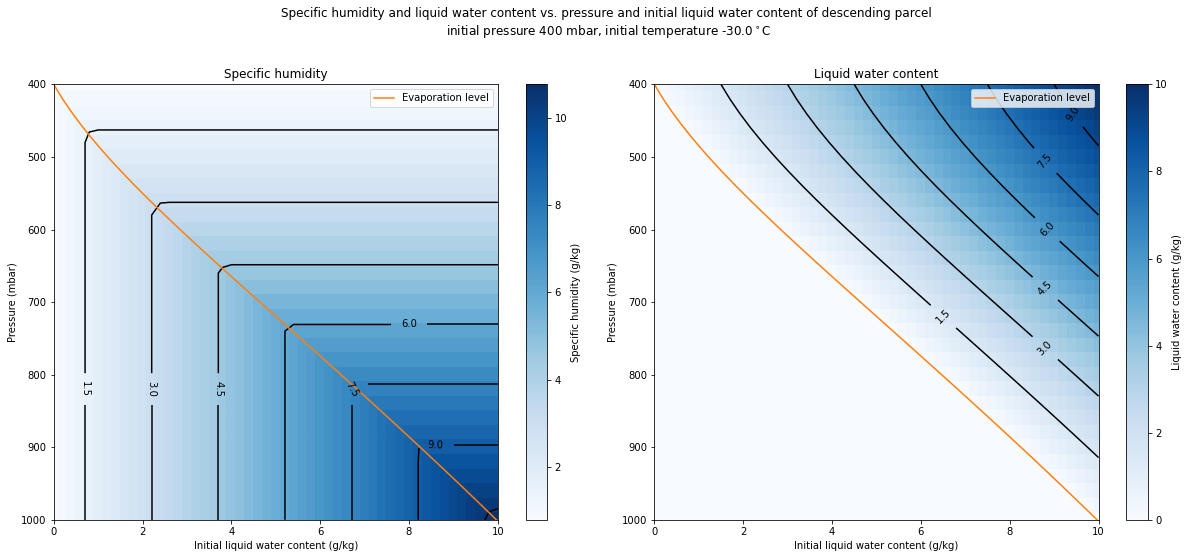

In [15]:
fig = plt.figure(figsize=(17,7))

# specific humidity image plot
ax1 = fig.add_subplot(121)
mesh = ax1.pcolormesh(
    initial_liquid_ratio*1e3, pressure, specific_humidity.T*1e3, 
    shading='nearest',
    cmap='Blues',
)
cbar = plt.colorbar(mesh)
cbar.set_label('Specific humidity (g/kg)')

contour = ax1.contour(
    initial_liquid_ratio*1e3, pressure, specific_humidity.T*1e3, 
    colors='k',
)
ax1.clabel(contour, fmt='%1.1f')

ax1.plot(initial_liquid_ratio*1e3, profile[1], color='tab:orange',
        label='Evaporation level')

ax1.set_ylim(np.max(pressure), np.min(pressure))
ax1.legend()
ax1.set(
    title=r'Specific humidity',
    xlabel='Initial liquid water content (g/kg)',
    ylabel='Pressure (mbar)',
)

# liquid water ratio image plot
ax2 = fig.add_subplot(122)
mesh = ax2.pcolormesh(
    initial_liquid_ratio*1e3, pressure, liquid_ratio.T*1e3, 
    shading='nearest',
    cmap='Blues',
)
cbar = plt.colorbar(mesh)
cbar.set_label('Liquid water content (g/kg)')

contour = ax2.contour(
    initial_liquid_ratio*1e3, pressure, liquid_ratio.T*1e3, 
    levels=np.arange(1.5, 10, 1.5),
    colors='k',
)
ax2.clabel(contour, fmt='%1.1f')

# evaporation level line
ax2.plot(initial_liquid_ratio*1e3, profile[1], color='tab:orange',
        label='Evaporation level')

ax2.set_ylim(np.max(pressure), np.min(pressure))
ax2.legend()
ax2.set(
    title=r'Liquid water content',
    xlabel='Initial liquid water content (g/kg)',
    ylabel='Pressure (mbar)',
)

fig.tight_layout()
fig.suptitle(
    r'Specific humidity and liquid water content vs. pressure and initial '
    'liquid water content of descending parcel \ninitial pressure 400 mbar, '
    'initial temperature '
    '{0:.1f}$^\circ$C'.format(initial_temperature[0].magnitude),
    y=1.1)
plt.show()

# fig.savefig(
#     fig_path + 'q_vs_p_and_q0.png', dpi=300, facecolor='w',
#     bbox_inches='tight')

The more liquid water is initially present, the further the parcel must descend before all the liquid evaporates, and the greater its final specific humidity.

## Specfic humidity vs. pressure and initial temperature for constant intial liquid water content

We now repeat the previous example, this time varying the initial
temperature and fixing the initial specific humidity.

In [23]:
%%time
pressure = np.arange(400, 1001, 20)*units.mbar
initial_temperature = np.arange(-40, 0.1, 1) * units.celsius
initial_liquid_ratio = np.ones(len(initial_temperature)) * 5e-3

profile = descent_profile_with_evaporation_level(
    pressure, initial_temperature, initial_liquid_ratio)
specific_humidity = specific_humidity_from_descent_profile(pressure, *profile)
liquid_ratio = actual_remaining_liquid_ratio(
    pressure, initial_temperature, initial_liquid_ratio)

CPU times: user 29.4 s, sys: 347 ms, total: 29.8 s
Wall time: 36.1 s


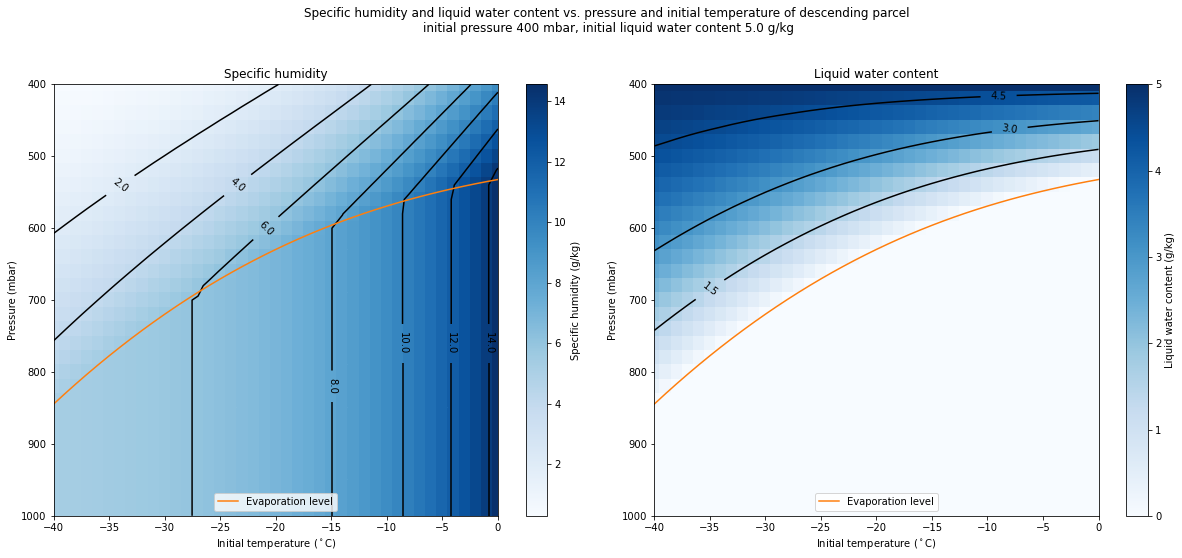

In [24]:
fig = plt.figure(figsize=(17,7))

# specific humidity image plot
ax1 = fig.add_subplot(121)
mesh = ax1.pcolormesh(
    initial_temperature, pressure, specific_humidity.T*1e3, 
    shading='nearest',
    cmap='Blues',
)
cbar = plt.colorbar(mesh)
cbar.set_label('Specific humidity (g/kg)')

contour = ax1.contour(
    initial_temperature, pressure, specific_humidity.T*1e3, 
    colors='k',
)
ax1.clabel(contour, fmt='%1.1f')

ax1.plot(initial_temperature, profile[1], color='tab:orange',
        label='Evaporation level')

ax1.set_ylim(np.max(pressure), np.min(pressure))
ax1.legend(loc='lower center')
ax1.set(
    title=r'Specific humidity',
    xlabel=r'Initial temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
)

# liquid water ratio image plot
ax2 = fig.add_subplot(122)
mesh = ax2.pcolormesh(
    initial_temperature, pressure, liquid_ratio.T*1e3, 
    shading='nearest',
    cmap='Blues',
)
cbar = plt.colorbar(mesh)
cbar.set_label('Liquid water content (g/kg)')

contour = ax2.contour(
    initial_temperature, pressure, liquid_ratio.T*1e3, 
    levels=np.arange(1.5, 10, 1.5),
    colors='k',
)
ax2.clabel(contour, fmt='%1.1f')

# evaporation level line
ax2.plot(initial_temperature, profile[1], color='tab:orange',
        label='Evaporation level')

ax2.set_ylim(np.max(pressure), np.min(pressure))
ax2.legend(loc='lower center')
ax2.set(
    title=r'Liquid water content',
    xlabel=r'Initial temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
)

fig.tight_layout()
fig.suptitle(
    r'Specific humidity and liquid water content vs. pressure and initial '
    'temperature of descending parcel \ninitial pressure 400 mbar, '
    'initial liquid water content '
    '{0:.1f} g/kg'.format(initial_liquid_ratio[0]*1e3),
    y=1.1)
plt.show()

# fig.savefig(
#     fig_path + 'q_vs_p_and_q0.png', dpi=300, facecolor='w',
#     bbox_inches='tight')

A parcel with a higher initial temperature has a higher initial and final specific humidity, but liquid water in it evaporates faster. 

## Modelling entrainment

Idea: consider the classic example from first-year calculus:
- We have a tank full of water with a given initial salt concentration that is continuously mixed
- We pour in water with a given salt concentration
- We drain water from the tank at the same rate it is poured in
- How does the salt concentration change over time?

Now replace the tank with an air parcel and the salt with water vapour.  
The rate of change of the specific humidity is the rate of vapour influx minus the rate of vapour outflux:
$$
    m\frac{dq}{dt} = q_{\mathrm{env}}(t) \frac{dm}{dt} - q \frac{dm}{dt}.
$$
If $\frac{1}{m}\frac{dm}{dt} \equiv r$ and $q_{\mathrm{env}}$ are independent of time, the ODE is separable:
$$
    \Leftrightarrow \qquad \int_{q_0}^q \frac{dq'}{q_{\mathrm{env}} - q'} = r \int_0^t dt' \\
    \Leftrightarrow \qquad - \log |q_{\mathrm{env}} - q'| + \log |q_{\mathrm{env}} - q_0| = rt \\
    \Leftrightarrow \qquad |q_{\mathrm{env}} - q'| = |q_{\mathrm{env}} - q_0| e^{-rt} \\
$$
and if $q_{\mathrm{env}} < q_0$ (the parcel is entraining drier air),
$$ q' = q_{\mathrm{env}} + (q_0 - q_{\mathrm{env}}) e^{-rt}. $$

A rough example is shown below.

In [18]:
q0 = 8e-3
q_env = 1e-3
# rough guess for r
density = mpcalc.density(600*units.mbar, -20*units.celsius, 4e-3)
volume = 1*units.meter**3
mass = density * volume
r = (1/mass * 10*units.liter * density / (1*units.min)).to(1/units.minute)

time = np.arange(0, 60*12 + 1, 10)*units.min # one hour
q = q_env + (q0 - q_env) * np.exp(-r * time)

[Text(0.5, 0, 'Time (min)'),
 Text(0, 0.5, 'Specific humidity (g/kg)'),
 Text(0.5, 1.0, 'A very basic entrainment model')]

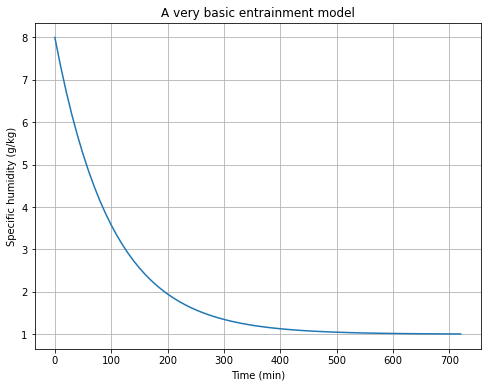

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(time, q*1e3)
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Specific humidity (g/kg)',
    title='A very basic entrainment model')

If $\frac{1}{m}\frac{dm}{dt} \equiv r$ and $q_{\mathrm{env}}$ are *not* independent of time, we can integrate the ODE numerically.

## Questions

- Is it possible for the parcel to be subsaturated and have condensed water suspended in it without that water evaporating until either the parcel saturates or no water is left? How do we deal with this non-equilibrium state?

## Possible next steps

- What determines the evaporation rate of precipitation falling through the parcel?
    - Droplet size
    - Terminal velocity
    - Droplet temperature (equal to the dew point?)
- Determine parcel buoyancy using equation given in *Knupp and Cotton (1985)*
    - Requires an environmental sounding
- Find typical entrainment rates from literature